In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [99]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


factors_list = ['因子_開盤前5分鐘', 
                "因子_開盤前15分鐘",
                "因子_開盤前所有時間"]
                # "因子_開盤前5x15分鐘"]
returns_list = ["回報_開盤後5分鐘", 
                "回報_開盤後15分鐘",
                "回報_開盤後到收盤",
                '回報_開盤5分鐘後到收盤', 
                '回報_開盤15分鐘後到收盤']

def get_df_from_mt5_csv(fnames):
    if isinstance(fnames, str):
        df = pd.read_csv(fnames, sep="\t")
        df.columns = ['da', 'time', "op", 'hi', "lo", "cl", "a", "b", "c"]
        df['da'] = pd.to_datetime(df['da'], format="%Y.%m.%d")
        return df.iloc[:, :6]

    elif isinstance(fnames, (list, tuple)):
        dfs = []
        for fname in fnames:
            df = pd.read_csv(fname, sep="\t")
            df.columns = ['da', 'time', "op", 'hi', "lo", "cl", "a", "b", "c"]
            df['da'] = pd.to_datetime(df['da'], format="%Y.%m.%d")
            dfs.append(df.iloc[:, :6])
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df['da'] = pd.to_datetime(combined_df['da'])  # Convert 'da' to datetime
        combined_df.sort_values(by=['da', 'time'], inplace=True)
        combined_df = combined_df.drop_duplicates(subset=['da', 'time'])
        return combined_df[:, 6]

    else:
        raise ValueError("fnames should be a string (single file) or a list/tuple of file paths")

def calc_ratio(x, type_=""):
    try:
        if type_ == "1":
            return x.iloc[0, 1] / x.iloc[0, 0] - 1  
        elif type_ == "2":
            return x.iloc[1, 1] / x.iloc[0, 0] - 1  
        else:
            return x.iloc[1, 1] / x.iloc[0, 0] - 1  
    except IndexError:
        return None  

def get_factor(df, d_early, d_late, factor_name):
    return (
    df[df['time'].isin([d_early, d_late])]
    .groupby("da", group_keys=False)[["op", "cl"]]  
    .apply(lambda x: calc_ratio(x, factor_name), include_groups=False)
    )
    
def get_simulated_return(df, d_early, d_late, return_name):
    return (
    df[df['time'].isin([d_early, d_late])]
    .groupby("da", group_keys=False)[["op", "cl"]]  
    .apply(lambda x: calc_ratio(x, return_name), include_groups=False)
    )
    
def df_factor_profit_bt(df, factors_list:list, returns_list:list, plots=True):
    ic_ratio_list = {}
    if len(factors_list) == 0: return; 
    
    for factor in factors_list:
        df['signal_dto'] = df[factor].apply(lambda x: 1 if x < 0 else -1)
        
        for ret in returns_list:
            df_temp = df[['signal_dto', ret]].dropna(how='any')
            ic_ratio = np.corrcoef(df_temp['signal_dto'], df_temp[ret])[0, 1]
            ic_ratio_list[f"{factor} for {ret}"] = ic_ratio
    ic_ratio_list = dict(sorted(ic_ratio_list.items(), key=lambda item: item[1], reverse=True))
    if plots:
        pass;
    return ic_ratio_list, df

def calculate_strategy_statistics(df, ret_column, risk_free_rate=0.02, plot=True):
    df = df.copy()

    df['cumulative_returns'] = df[ret_column].cumsum()

    df['cumulative_max'] = df['cumulative_returns'].cummax()  # Track the running maximum
    df['drawdown'] = df['cumulative_returns'] - df['cumulative_max']  # Difference from the peak
    df['drawdown_pct'] = df['drawdown'] / df['cumulative_max']  # Drawdown as percentage of peak
    max_drawdown = df['drawdown_pct'].min()  # Most negative value represents maximum drawdown

    daily_return_std = df[ret_column].std()
    sharpe_ratio = (df[ret_column].mean() - risk_free_rate / 252) / daily_return_std * np.sqrt(252)

    # Sortino Ratio (Uses downside volatility)
    downside_returns = df[ret_column][df[ret_column] < 0]
    downside_std = downside_returns.std()
    sortino_ratio = (df[ret_column].mean() - risk_free_rate / 252) / downside_std * np.sqrt(252)

    # Calmar Ratio (Annualized Return / MDD)
    annual_return = df[ret_column].mean() * 252
    calmar_ratio = abs(annual_return / max_drawdown)

    # Win Rate & Profit Factor
    win_trades = df[ret_column][df[ret_column] > 0]
    loss_trades = df[ret_column][df[ret_column] < 0]
    win_rate = len(win_trades) / len(df[ret_column])
    profit_factor = win_trades.sum() / abs(loss_trades.sum())

    # Biggest Win / Loss Per Trade
    biggest_win = df[ret_column].max()
    biggest_loss = df[ret_column].min()

    # Longest Winning Streak & Longest Losing Streak
    win_streak = 0
    loss_streak = 0
    max_win_streak = 0
    max_loss_streak = 0

    for r in df[ret_column]:
        if r > 0:
            win_streak += 1
            loss_streak = 0
        elif r < 0:
            loss_streak += 1
            win_streak = 0
        else:
            win_streak = loss_streak = 0  # Reset streak if it's zero

        max_win_streak = max(max_win_streak, win_streak)
        max_loss_streak = max(max_loss_streak, loss_streak)

    # Results Dictionary
    stats = {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown (%)": max_drawdown,
        "Annualized Return (%)": annual_return * 100,
        "Win Rate (%)": win_rate * 100,
        "Profit Factor": profit_factor,
        "Biggest Win Per Trade": biggest_win,
        "Biggest Loss Per Trade": biggest_loss,
        "Longest Winning Streak": max_win_streak,
        "Longest Losing Streak": max_loss_streak
    }

    if plot:
        # Create subplots with 2 y-axes and 2 rows
        fig = make_subplots(
            rows=2, cols=1,  
            shared_xaxes=True,
            vertical_spacing=0.1,  
            subplot_titles=("策略 vs. 大盤", "回檔"),
            specs=[[{"secondary_y": True}], [{}]]  
        )

        # Cumulative Profit Line (Primary y-axis)
        fig.add_trace(go.Scatter(
            x=df.index, y=df['cumulative_returns'],
            mode="lines", name="策略", line=dict(color="blue")
        ), row=1, col=1, secondary_y=False)  

        # OP Line (Secondary y-axis)
        fig.add_trace(go.Scatter(
            x=df.index, y=df['op'],
            mode="lines", name="大盤", line=dict(color="orange")
        ), row=1, col=1, secondary_y=True)  

        # Add MDD Trace
        fig.add_trace(go.Scatter(
            x=df.index, y=df['drawdown'],
            fill='tozeroy', mode='lines', name="回檔",
            line=dict(color="red")
        ), row=2, col=1)  

        # Update layout with title, axis labels, and MDD settings
        fig.update_layout(
            title="策略1--Sila Smoka",
            xaxis_title="時間",
            yaxis_title="策略收益",
            yaxis2_title="大盤",  
            yaxis2=dict(
                overlaying='y',  
                side='right'  
            ),
            height=800,
            width=1200,
            xaxis=dict(
                title="時間",
                showgrid=True,
                showline=True,
                zeroline=False,  
            ),
        )
        fig.show()

    return stats

def get_factor_returns(returned_df, us30_data_temp) -> pd.DataFrame:
    # simulated returns
    returned_df['回報_開盤後5分鐘'] = get_factor(us30_data_temp, "16:30:00", "16:35:00", "1")
    returned_df['回報_開盤後15分鐘'] = get_factor(us30_data_temp, "16:30:00", "16:40:00", "2")
    returned_df['回報_開盤後到收盤'] = get_factor(us30_data_temp, "16:30:00", "23:55:00", "2")
    returned_df['回報_開盤5分鐘後到收盤'] = get_factor(us30_data_temp, "16:35:00", "23:55:00", "2")
    returned_df['回報_開盤15分鐘後到收盤'] = get_factor(us30_data_temp, "16:45:00", "23:55:00", "2")
    # factors
    returned_df['因子_開盤前5分鐘'] = get_factor(us30_data_temp, "16:25:00", "16:30:00", "1")
    returned_df['因子_開盤前15分鐘'] = get_factor(us30_data_temp, "16:15:00", "16:25:00", "2")
    returned_df['因子_開盤前所有時間'] = get_factor(us30_data_temp, "01:00:00", "16:25:00", "2")
    return returned_df

In [100]:
# overall IC
list_ = ['us30.csv', 'us30_20240823_20230825.csv', "US30_20250130only.csv"]
us30_data = get_df_from_mt5_csv("us30.csv")
# df = get_df_from_mt5_csv([list_[0], list_[1], list_[2]])

In [103]:
from tqdm import tqdm # type: ignore

# 如果
def get_daily_ic_ratio_dataframe(rolling, ic_ratio_list, grouped_df, factors_list:list, returns_list:list, plots=True) -> tuple[dict, pd.DataFrame]:
    if len(factors_list) == 0: print("get no data for factors_list"); return;
    if len(factors_list) < rolling: pass; 
    
    for factor in factors_list:
        grouped_df['signal_dto'] = grouped_df[factor].apply(lambda x: 1 if x < 0 else -1)
        
        for ret in returns_list:
            df_temp = grouped_df[['signal_dto', ret]].dropna(how='any')
            ic_ratio = np.corrcoef(df_temp['signal_dto'], df_temp[ret])[0, 1]
            
            key_name = f"{factor} for {ret}"
            ic = np.abs(ic_ratio)
            if key_name not in list(ic_ratio_list.keys()):
                ic_ratio_list[key_name] = [ic]
            ic_ratio_list[key_name].append(ic)
    # ic_ratio_list = dict(sorted(ic_ratio_list.items(), key=lambda item: item[1], reverse=True))
    if plots:
        pass;
    return ic_ratio_list, grouped_df

################################################################
rolling = 20
list_trading_date = sorted(list(set(us30_data.da)))[rolling:]
ic_ratio_list = {}
for today in tqdm(list_trading_date):
    us30_data_temp = us30_data[us30_data['da'] <= today]
    grouped_df = us30_data_temp[us30_data_temp['time'] == "16:30:00"].set_index('da').iloc[-rolling:, :]
    grouped_df = get_factor_returns(returned_df=grouped_df, us30_data_temp=us30_data_temp)
    
    ic_ratio_list, grouped_df = get_daily_ic_ratio_dataframe(
        rolling = rolling,
        ic_ratio_list = ic_ratio_list,
        grouped_df = grouped_df, 
        factors_list=factors_list, 
        returns_list=returns_list)
ic_df = pd.DataFrame.from_dict(ic_ratio_list).iloc[1: :]
ic_df.index = list_trading_date

100%|██████████| 349/349 [00:19<00:00, 18.32it/s]


In [104]:
fig = go.Figure()

for i in range(len(ic_df.columns)):
    fig.add_trace(go.Scatter(
        x=ic_df.index, 
        y=ic_df.iloc[:, i],
        mode="lines", 
        name=ic_df.columns[i],
        visible='legendonly'  # Hide by default
    ))  

fig.show()

In [109]:
# ic_df 是所有策略的因子值
# return_df 是所有策略的日報酬率

daily_df = us30_data[us30_data['time'] == "16:30:00"].set_index('da')
daily_df = get_factor_returns(
    returned_df = daily_df,
    us30_data_temp = us30_data)

return_df = pd.DataFrame().reindex_like(ic_df)
for factor in factors_list:
    for ret in returns_list:
        factor_return_name = f"{factor} for {ret}"
        daily_df['signal_dto'] = daily_df[factor].apply(lambda x: 1 if x < 0 else -1)
        return_df[factor_return_name] = -daily_df['signal_dto'] * daily_df[ret]
factor_return_df = return_df[ic_df.columns]

In [115]:
def get_stats(factor_return_df) -> None:
    if isinstance(factor_return_df, list):
        for i in factor_return_df:
            print("=======================")
            print(f"""
DataFrame Stats: 
    length -> {len(i)}
    column length -> {len(i.columns)}
    start date -> {i.index[0]}    
    end date -> {i.index[-1]} 
                """)
    else:
        print(f"""
DataFrame Stats: 
    length -> {len(factor_return_df)}
    column length -> {len(factor_return_df.columns)}
    start date -> {factor_return_df.index[0]}    
    end date -> {factor_return_df.index[-1]} 
            """)
        
    return None
get_stats([factor_return_df, ic_df], )


DataFrame Stats: 
    length -> 349
    column length -> 15
    start date -> 2023-09-22 00:00:00    
    end date -> 2025-01-29 00:00:00 
                

DataFrame Stats: 
    length -> 349
    column length -> 15
    start date -> 2023-09-22 00:00:00    
    end date -> 2025-01-29 00:00:00 
                


Sharpe Ratio: 0.10
Sortino Ratio: 0.16
Calmar Ratio: 0.00
Max Drawdown (%): -7.87
Annualized Return (%): 2.26
Win Rate (%): 51.63
Profit Factor: 1.16
Biggest Win Per Trade: 0.01
Biggest Loss Per Trade: -0.01
Longest Winning Streak: 6.00
Longest Losing Streak: 6.00


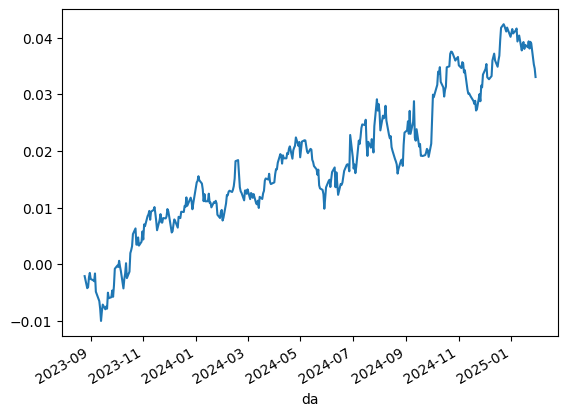

In [116]:
# compare each factor with/without filteration


def calculate_strategy_statistics(df, ret_column, risk_free_rate=0.02, plot=True):
    df = df.copy()

    # Calculate Cumulative Returns
    df['cumulative_returns'] = df[ret_column].cumsum()

    # Maximum Drawdown (MDD)
    df['cumulative_max'] = df['cumulative_returns'].cummax()  # Track the running maximum
    df['drawdown'] = df['cumulative_returns'] - df['cumulative_max']  # Difference from the peak
    df['drawdown_pct'] = df['drawdown'] / df['cumulative_max']  # Drawdown as percentage of peak
    max_drawdown = df['drawdown_pct'].min()  # Most negative value represents maximum drawdown

    # Sharpe Ratio (Annualized)
    daily_return_std = df[ret_column].std()
    sharpe_ratio = (df[ret_column].mean() - risk_free_rate / 252) / daily_return_std * np.sqrt(252)

    # Sortino Ratio (Uses downside volatility)
    downside_returns = df[ret_column][df[ret_column] < 0]
    downside_std = downside_returns.std()
    sortino_ratio = (df[ret_column].mean() - risk_free_rate / 252) / downside_std * np.sqrt(252)

    # Calmar Ratio (Annualized Return / MDD)
    annual_return = df[ret_column].mean() * 252
    calmar_ratio = abs(annual_return / max_drawdown)

    # Win Rate & Profit Factor
    win_trades = df[ret_column][df[ret_column] > 0]
    loss_trades = df[ret_column][df[ret_column] < 0]
    win_rate = len(win_trades) / len(df[ret_column])
    profit_factor = win_trades.sum() / abs(loss_trades.sum())

    # Biggest Win / Loss Per Trade
    biggest_win = df[ret_column].max()
    biggest_loss = df[ret_column].min()

    # Longest Winning Streak & Longest Losing Streak
    win_streak = 0
    loss_streak = 0
    max_win_streak = 0
    max_loss_streak = 0

    for r in df[ret_column]:
        if r > 0:
            win_streak += 1
            loss_streak = 0
        elif r < 0:
            loss_streak += 1
            win_streak = 0
        else:
            win_streak = loss_streak = 0  # Reset streak if it's zero

        max_win_streak = max(max_win_streak, win_streak)
        max_loss_streak = max(max_loss_streak, loss_streak)

    # Results Dictionary
    stats = {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown (%)": max_drawdown,
        "Annualized Return (%)": annual_return * 100,
        "Win Rate (%)": win_rate * 100,
        "Profit Factor": profit_factor,
        "Biggest Win Per Trade": biggest_win,
        "Biggest Loss Per Trade": biggest_loss,
        "Longest Winning Streak": max_win_streak,
        "Longest Losing Streak": max_loss_streak
    }

    if plot:
        # Create subplots with 2 y-axes and 2 rows
        fig = make_subplots(
            rows=2, cols=1,  
            shared_xaxes=True,
            vertical_spacing=0.1,  
            subplot_titles=("策略 vs. 大盤", "回檔"),
            specs=[[{"secondary_y": True}], [{}]]  
        )

        # Cumulative Profit Line (Primary y-axis)
        fig.add_trace(go.Scatter(
            x=df.index, y=df['cumulative_returns'],
            mode="lines", name="策略", line=dict(color="blue")
        ), row=1, col=1, secondary_y=False)  

        # OP Line (Secondary y-axis)
        fig.add_trace(go.Scatter(
            x=df.index, y=df['op'],
            mode="lines", name="大盤", line=dict(color="orange")
        ), row=1, col=1, secondary_y=True)  

        # Add MDD Trace
        fig.add_trace(go.Scatter(
            x=df.index, y=df['drawdown'],
            fill='tozeroy', mode='lines', name="回檔",
            line=dict(color="red")
        ), row=2, col=1)  

        # Update layout with title, axis labels, and MDD settings
        fig.update_layout(
            title="策略1--Sila Smoka",
            xaxis_title="時間",
            yaxis_title="策略收益",
            yaxis2_title="大盤",  
            yaxis2=dict(
                overlaying='y',  
                side='right'  
            ),
            height=800,
            width=1200,
            xaxis=dict(
                title="時間",
                showgrid=True,
                showline=True,
                zeroline=False,  
            ),
        )
        fig.show()

    return stats


factor = "因子_開盤前5分鐘"
ret = "回報_開盤後5分鐘"
daily_df['signal_dto'] = daily_df[factor].apply(lambda x: 1 if x < 0 else -1)

daily_df['profit_dto_5'] = daily_df['signal_dto'] * daily_df[ret]
daily_df['profit_dto_5'].cumsum().plot()


stats = calculate_strategy_statistics(daily_df, 'profit_dto_5')

# Print statistics
for k, v in stats.items():
    print(f"{k}: {v:.2f}")